# <a href="https://miptstats.gitlhub.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [45]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [46]:
!pip install -q torchinfo

In [47]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score
import os
from pathlib import Path

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST (переименовал модели и перезапустил)


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Сразу везде зафиксируем random_state для воспроизводимости результатов

In [48]:
np.random.seed(42)
torch.manual_seed(42)

Загрузим датаcет из `torchvision.datasets`.

In [49]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
classes = [str(i) for i in range(10)]  # Классы объектов в датасете

Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


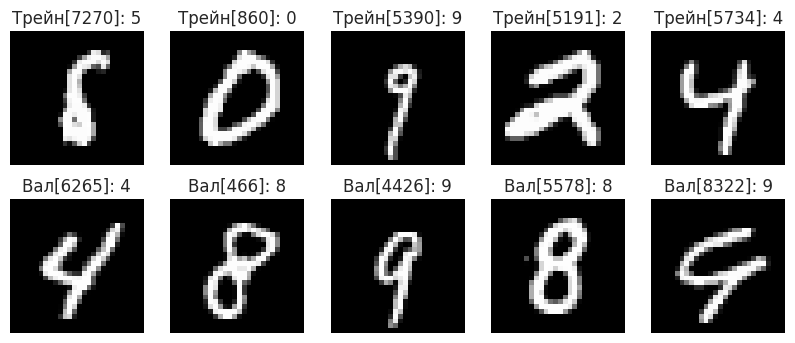

In [50]:
sample_size = 5  # отрисуем по sample_size картинок из каждой выборки
train_indices, val_indices = np.random.randint(0, 10000, sample_size), np.random.randint(0, 10000, sample_size)
print(f"Размер картинки:{train_dataset[0][0].shape}")

plt.figure(figsize=(10, 4))
for i in range(sample_size):
    for dataset, indices, dataset_name in zip([train_dataset, val_dataset],[train_indices, val_indices],['Трейн','Вал']):
        plt.subplot(2, sample_size, 1+i + {'Трейн':0,'Вал':sample_size}[dataset_name])
        plt.imshow(dataset[indices[i]][0].permute(1, 2, 0).repeat(1, 1, 3))  # 1xHxW -> HxWx3
        plt.title(f"{dataset_name}[{indices[i]}]: {classes[dataset[indices[i]][1]]}")
        plt.axis("off")

Создайте генераторы батчей.

In [51]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Заранее перепишем все полезные функции с лекции

In [52]:
def print_epoch(epoch, num_epochs, history, t):
    """Вывод информации про эпоху"""
    clear_output(wait=True)
    print("\nEpoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("train loss: {:.6f}".format(history["loss"]["train"][-1]), end=', ')
    print("train accuracy: {:.2f} %".format(history["acc"]["train"][-1] * 100))
    print("val loss:   {:.6f}".format(history["loss"]["val"][-1]), end=', ')
    print("val accuracy:   {:.2f} %".format(history["acc"]["val"][-1] * 100))

In [53]:
def log(history, loss, acc, num_batches, mode):
    """Логгирование лосса и точности"""
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)

In [54]:
def get_batch_loss(X_batch, y_batch, model, criterion, current_loss, current_acc):
    """Подсчет лосса (без backward pass)"""
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    logits = model(X_batch)
    loss = criterion(logits, y_batch.long().to(device))
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc

In [55]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epochs=40):
    """Обучение модели"""
    history = defaultdict(lambda: defaultdict(list))
    for epoch in tqdm(range(num_epochs)):
        train_loss, val_loss, train_acc, val_acc = 0, 0, 0, 0
        start_time = time.time()
        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        for X_batch, y_batch in train_loader:
            loss, train_loss, train_acc = get_batch_loss(X_batch, y_batch, model, criterion, train_loss, train_acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        log(history, train_loss, train_acc, len(train_loader), "train")
        # ----------------------   ВАЛИДАЦИЯ   ---------------------#
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                _, val_loss, val_acc = get_batch_loss(X_batch, y_batch, model, criterion, val_loss, val_acc)
        log(history, val_loss, val_acc, len(val_loader), "val")
        print_epoch(epoch, num_epochs, history, time.time() - start_time)
    return history

In [56]:
def plot_histories(histories):
    """Визуализация лосса и метрики по нескольким историям"""
    sns.set_style("darkgrid")
    colors = ["darkblue", "blue", "limegreen", "green", "red", "darkred", "purple"]
    fig, axs = plt.subplots(2, 1, figsize=(16, 12))
    epochs = np.min([len(histories[key]["loss"]["train"]) for key in histories.keys()])
    for i, (name, history) in enumerate(histories.items()):
        axs[0].set_title("Лосс")
        axs[0].plot(history["loss"]["train"][:epochs], label=name, lw=2, c=colors[i])
        axs[0].plot(history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[0].set_xlabel("Эпоха")
        axs[0].set_ylim([0, 0.12])
        axs[1].set_title("Точность")
        axs[1].plot(history["acc"]["train"][:epochs], label=name, lw=2, c=colors[i])
        axs[1].plot(history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--")
        axs[1].set_xlabel("Эпоха")
        axs[1].set_ylim([0.975, 1])
        axs[1].legend()
    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

Отмечу, что в идеале (для корректности экспериментов и упрощения их интерпретации) все модели должны отличаться от бейзлайна на некоторые атомарные модификации. Так будет проще подтвердить или опровергнуть гипотезы о влиянии архитектуры на качество предсказания. Однако при таких модификациях почти неизбежно поменяется суммарное число параметров. Больше параметров не означает бОльшее качество, но все равно честнее сравнивать архитектуры с примерно совпадающим числом параметров, поэтому постараемся это ограничение тоже соблюсти.  

Сравним следующие архитектуры:  
**model_baseline** - бейзлайн, архитектура с лекции (2 сверточных + 2 линейных слоя, max-пулинг). Единственное, подстроил размерности под размер входа MNIST. 430k параметров  
**model_1layer** - как model_baseline, но оставим только 1 сверточный слой. Плюс подстроим другие слои так, чтобы выравнять суммарное число параметров (далее это действие подразумевается)  
**model_3layer** - как model_baseline, но 3 сверточных слоя  
**model_1linear** - как model_baseline, но в голове только 1 линейный слой   
**model_3linear** - как model_baseline, но в голове 3 линейных слоя  
*(гипотеза: model_3layer покажет наилучший результат, т.к. за счет нового сверточного слоя модель может выявлять более сложные паттерны)*   
  
Мне еще было интересно, кроме этих пяти моделей, сравнить с бейзлайном следующие:  
**model_avgpool** - как model_baseline, но вместо max-пулинга - avg-пулинг *(гипотеза: не увидим прироста по качеству, но время работы может увеличиться)*  
**model_stride2** - как model_baseline, но вместо max-пулинга - страйд=2 в свертках *(гипотеза: не увидим прироста по качеству, но будет работать быстрее)*  

In [57]:
model_baseline = nn.Sequential(  # бейзлайн с лекции
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_1layer = nn.Sequential(  # как model_baseline, но минус один сверточный слой
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1690, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_3layer = nn.Sequential(  # как model_baseline, но плюс один сверточный слой
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=140, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=140, out_channels=256, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=256, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_1linear = nn.Sequential(  # как model_baseline, но только один линейный слой в голове
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=800, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=20000, out_features=10),
).to(device)

model_3linear = nn.Sequential(  # как model_baseline, но плюс один линейный слой
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=800, out_features=400),
    nn.ReLU(),
    nn.Linear(in_features=400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_avgpool = nn.Sequential(  # как model_baseline, но вместо max-пулинга - avg-пулинг
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.AvgPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.AvgPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_stride2 = nn.Sequential(  # как model_baseline, но вместо пулинга - страйд 2 в свертках
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=45, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1620, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [58]:
models = [model_baseline, model_1layer, model_3layer, model_1linear, model_3linear, model_avgpool, model_stride2]
for idx, cnn in enumerate(models):
    try:
        display(summary(cnn, input_size=(1, 1, 28, 28)))
        print('\n')
    except Exception as e:  # тут происходил подгон размерностей
        print(idx)
        raise e

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 26, 26]           100
├─MaxPool2d: 1-2                         [1, 10, 13, 13]           --
├─ReLU: 1-3                              [1, 10, 13, 13]           --
├─Flatten: 1-4                           [1, 1690]                 --
├─Linear: 1-5                            [1, 256]                  432,896
├─ReLU: 1-6                              [1, 256]                  --
├─Linear: 1-7                            [1, 10]                   2,570
Total params: 435,566
Trainable params: 435,566
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 1.74
Estimated Total Size (MB): 1.80

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 140, 11, 11]          40,460
├─MaxPool2d: 1-5                         [1, 140, 5, 5]            --
├─ReLU: 1-6                              [1, 140, 5, 5]            --
├─Conv2d: 1-7                            [1, 256, 3, 3]            322,816
├─MaxPool2d: 1-8                         [1, 256, 1, 1]            --
├─ReLU: 1-9                              [1, 256, 1, 1]            --
├─Flatten: 1-10                          [1, 256]                  --
├─Linear: 1-11                           [1, 256]                  65,792
├─ReLU: 1-12                             [1, 256]                  --
├

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 800, 11, 11]          231,200
├─MaxPool2d: 1-5                         [1, 800, 5, 5]            --
├─ReLU: 1-6                              [1, 800, 5, 5]            --
├─Flatten: 1-7                           [1, 20000]                --
├─Linear: 1-8                            [1, 10]                   200,010
Total params: 431,530
Trainable params: 431,530
Non-trainable params: 0
Total mult-adds (M): 28.39
Input size (MB): 0.00
Forward/backward pass size (MB): 0.95
Params size (MB): 1.73
Estimated Total Size (MB): 2.68

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 32, 11, 11]           9,248
├─MaxPool2d: 1-5                         [1, 32, 5, 5]             --
├─ReLU: 1-6                              [1, 32, 5, 5]             --
├─Flatten: 1-7                           [1, 800]                  --
├─Linear: 1-8                            [1, 400]                  320,400
├─ReLU: 1-9                              [1, 400]                  --
├─Linear: 1-10                           [1, 256]                  102,656
├─ReLU: 1-11                             [1, 256]                  --
├─Linear: 1-12                           [1, 10]                   2,57

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─AvgPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─AvgPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 13, 13]           320
├─ReLU: 1-2                              [1, 32, 13, 13]           --
├─Conv2d: 1-3                            [1, 45, 6, 6]             13,005
├─ReLU: 1-4                              [1, 45, 6, 6]             --
├─Flatten: 1-5                           [1, 1620]                 --
├─Linear: 1-6                            [1, 256]                  414,976
├─ReLU: 1-7                              [1, 256]                  --
├─Linear: 1-8                            [1, 10]                   2,570
Total params: 430,871
Trainable params: 430,871
Non-trainable params: 0
Total mult-adds (M): 0.94
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 1.72
Estimated Total Size (MB): 1.79

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

Чтобы содержимое выхода не затиралось, запустим обучение моделей в разных ячейках

In [59]:
logs = {}

def train_one_model(cnn, name, logs):
    """Обучение одной модели в ячейке"""
    print(f'{name}:\n')
    loss = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(cnn.parameters())
    history = train(cnn, loss, opt, train_loader, val_loader)  # по умолчанию num_epochs=40
    logs[name] = history
    torch.save(cnn.state_dict(), f"{name}.pth")

In [60]:
train_one_model(model_baseline, 'model_baseline', logs)

100%|██████████| 40/40 [06:36<00:00,  9.92s/it]


Epoch 40 of 40 took 8.796 s
train loss: 0.000010, train accuracy: 100.00 %
val loss:   0.054917, val accuracy:   99.25 %


In [61]:
train_one_model(model_1layer, 'model_1layer', logs)

100%|██████████| 40/40 [05:55<00:00,  8.88s/it]


Epoch 40 of 40 took 9.009 s
train loss: 0.002046, train accuracy: 99.93 %
val loss:   0.082549, val accuracy:   98.74 %


In [62]:
train_one_model(model_3layer, 'model_3layer', logs)

100%|██████████| 40/40 [06:34<00:00,  9.87s/it]


Epoch 40 of 40 took 9.894 s
train loss: 0.004051, train accuracy: 99.89 %
val loss:   0.088036, val accuracy:   98.91 %


In [63]:
train_one_model(model_1linear, 'model_1linear', logs)

100%|██████████| 40/40 [06:54<00:00, 10.36s/it]


Epoch 40 of 40 took 10.411 s
train loss: 0.000000, train accuracy: 100.00 %
val loss:   0.062313, val accuracy:   99.23 %


In [64]:
train_one_model(model_3linear, 'model_3linear', logs)

100%|██████████| 40/40 [06:19<00:00,  9.48s/it]


Epoch 40 of 40 took 9.724 s
train loss: 0.000000, train accuracy: 100.00 %
val loss:   0.048010, val accuracy:   99.40 %


In [65]:
train_one_model(model_avgpool, 'model_avgpool', logs)

100%|██████████| 40/40 [06:13<00:00,  9.33s/it]


Epoch 40 of 40 took 9.363 s
train loss: 0.002628, train accuracy: 99.91 %
val loss:   0.078314, val accuracy:   98.80 %


In [66]:
train_one_model(model_stride2, 'model_stride2', logs)

100%|██████████| 40/40 [06:24<00:00,  9.62s/it]


Epoch 40 of 40 took 9.560 s
train loss: 0.002480, train accuracy: 99.94 %
val loss:   0.083661, val accuracy:   98.76 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

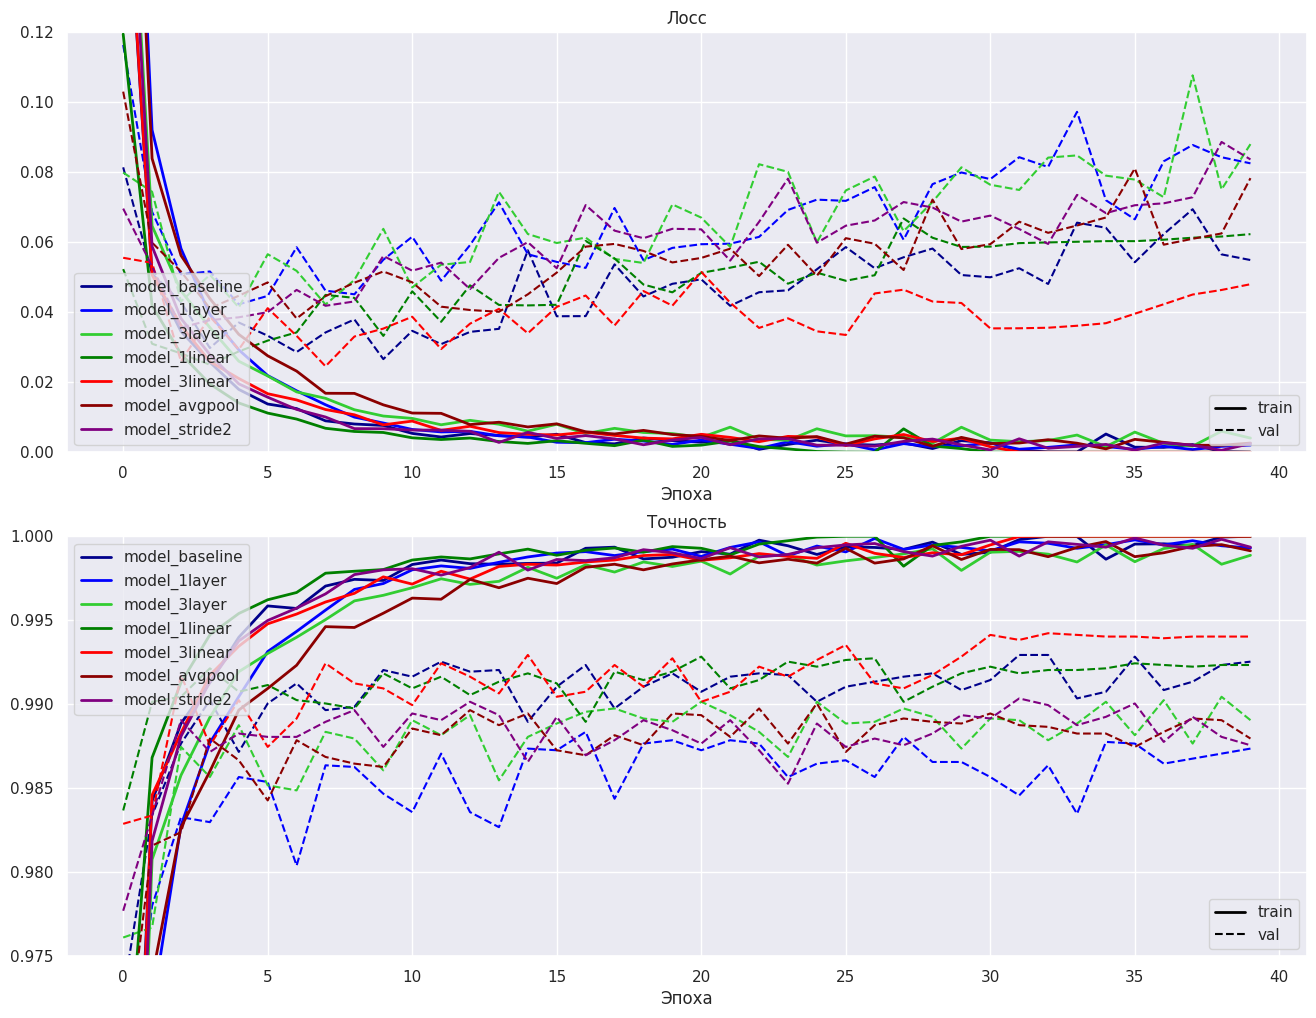

In [67]:
plot_histories(logs)

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1**

**Время обучения:**  
По прогресс-бару tqdm видно, что при фиксированном суммарном числе параметров  
а) чем больше сверточных слоев (в ущерб ширине всех остальных), тем дольше идет средняя эпоха   
б) чем меньше линейных слов (в пользу ширины всех остальных), тем дольше идет средняя эпоха  
в) эксперимент со stride=2 отработал быстрее, чем c avg-пулингом, а эксперимент с avg-пулингом - быстрее, чем с max-пулингом  

Выборка моделей, конечно, небольшая, но можно попробовать сделать несколько выводов:  
Во-первых, пункты а-б контринтуитивны, ведь вычислительная сложность свертки меньше, чем у линейного слоя. Тем не менее, это наблюдение показывает, что реальное время работы и вычисительная сложность - это разные вещи. Меньшая сложность свертки лишь гарантирует, что существует характерный размер входа, начиная с которого свертка будет работать быстрее. Однако на маленьких входах все может быть по-другому, например, если какие-то отдельные операции занимают много времени. Я нашел несколько подтверждений на форумах (<a href="https://stackoverflow.com/questions/47935430/torch-why-convolution-layer-is-even-slower-than-full-connect-linear-layer-when">пример</a>), где упоминалось, что свертка из torch дублирует входной тензор, из-за чего на маленьких входах может работать дольше. Но вообще, при прочих равных, свертка работает быстрее линейного слоя    
Во-вторых, пункт в показывает, что увеличение страйда - более эффективно по времени для понижения размерности, чем пулинг. Это звучит логично, ведь совершается меньше операций свертки (с шагом 2 вместо 1) и при этом не совершаются операции пулинга. Я слышал, что в современных сетях для CV все реже используют пулинг, заменяя его бОльшим страйдом  
  
**Качество предсказания:**  
По графикам лосса и точности видно, что  
а) на трейне все модели работают примерно одинаково  
б) по динамике лосса на валидации можно выделить худшие (model_1layer, model_3layer, model_stride2) и лучшие (model_baseline, model_1linear, model_3linear) модели  
в) по динамике точности на валидации можно выделить худшие (model_1layer, model_3layer, model_stride2) и лучшие (model_baseline, model_1linear, model_3linear) модели

Во-первых, хороший знак, что распределение моделей по качеству судя-по-лоссу и судя-по-точности примерно совпадают (как минимум, выбор модели упрощается).  
Во-вторых, модели model_1layer, model_3layer отличались от бейзлайна кол-вом сверточных слоев (-1 и +1), но работают чуть хуже него, а значит, текущее кол-во сверточных слоев оптимально при фиксированном суммарном кол-ве параметров сети. Вообще, учитывая, что бейзлайн (model_baseline) находится в топе моделей, можно считать, что его архитектура оптимальна при заданных условиях  

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Сравним следующие архитектуры:  
**model_baseline** - бейзлайн, ядра 3x3, 3x3  
**model_3x3_5x5** - 3x3, 5x5   
**model_5x5_3x3** - 5x5, 3x3  
**model_5x5_5x5** - 5x5, 5x5  
**model_1x1_1x1** - 1x1, 1x1, ради интереса  

In [68]:
model_baseline = nn.Sequential(  # 3x3, 3x3
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_3x3_5x5 = nn.Sequential(  # 3x3, 5x5
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_5x5_3x3 = nn.Sequential(  # 5x5, 3x3
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1600, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_5x5_5x5 = nn.Sequential(  # 5x5, 5x5
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1024, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

model_1x1_1x1 = nn.Sequential(  # 1x1, 1x1
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=3136, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

In [69]:
models = [model_baseline, model_3x3_5x5, model_5x5_3x3, model_5x5_5x5, model_1x1_1x1]
for idx, cnn in enumerate(models):
    try:
        display(summary(cnn, input_size=(1, 1, 28, 28)))
        print('\n')
    except Exception as e:  # тут происходил подгон размерностей
        print(idx)
        raise e

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 11, 11]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,242
Trainable params: 431,242
Non-trainable params: 0
Total mult-adds (M): 2.87
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 26, 26]           320
├─MaxPool2d: 1-2                         [1, 32, 13, 13]           --
├─ReLU: 1-3                              [1, 32, 13, 13]           --
├─Conv2d: 1-4                            [1, 64, 9, 9]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 316,554
Trainable params: 316,554
Non-trainable params: 0
Total mult-adds (M): 4.63
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 10, 10]           18,496
├─MaxPool2d: 1-5                         [1, 64, 5, 5]             --
├─ReLU: 1-6                              [1, 64, 5, 5]             --
├─Flatten: 1-7                           [1, 1600]                 --
├─Linear: 1-8                            [1, 256]                  409,856
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 431,754
Trainable params: 431,754
Non-trainable params: 0
Total mult-adds (M): 2.74
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 24, 24]           832
├─MaxPool2d: 1-2                         [1, 32, 12, 12]           --
├─ReLU: 1-3                              [1, 32, 12, 12]           --
├─Conv2d: 1-4                            [1, 64, 8, 8]             51,264
├─MaxPool2d: 1-5                         [1, 64, 4, 4]             --
├─ReLU: 1-6                              [1, 64, 4, 4]             --
├─Flatten: 1-7                           [1, 1024]                 --
├─Linear: 1-8                            [1, 256]                  262,400
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 317,066
Trainable params: 317,066
Non-trainable params: 0
Total mult-adds (M): 4.03
Input size (MB): 0.00
Forward/backward pass 

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           64
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─ReLU: 1-3                              [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           2,112
├─MaxPool2d: 1-5                         [1, 64, 7, 7]             --
├─ReLU: 1-6                              [1, 64, 7, 7]             --
├─Flatten: 1-7                           [1, 3136]                 --
├─Linear: 1-8                            [1, 256]                  803,072
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 807,818
Trainable params: 807,818
Non-trainable params: 0
Total mult-adds (M): 1.27
Input size (MB): 0.00
Forward/backward pass si

Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

In [70]:
logs = {}  # чистим логи перед новым запуском

In [71]:
train_one_model(model_baseline, 'model_baseline', logs)

100%|██████████| 40/40 [06:13<00:00,  9.35s/it]


Epoch 40 of 40 took 9.327 s
train loss: 0.002444, train accuracy: 99.93 %
val loss:   0.064187, val accuracy:   98.96 %


In [72]:
train_one_model(model_3x3_5x5, 'model_3x3_5x5', logs)

100%|██████████| 40/40 [06:17<00:00,  9.43s/it]


Epoch 40 of 40 took 8.911 s
train loss: 0.000314, train accuracy: 99.99 %
val loss:   0.049403, val accuracy:   99.38 %


In [73]:
train_one_model(model_5x5_3x3, 'model_5x5_3x3', logs)

100%|██████████| 40/40 [06:12<00:00,  9.32s/it]


Epoch 40 of 40 took 9.392 s
train loss: 0.000000, train accuracy: 100.00 %
val loss:   0.055302, val accuracy:   99.34 %


In [74]:
train_one_model(model_5x5_5x5, 'model_5x5_5x5', logs)

100%|██████████| 40/40 [06:17<00:00,  9.43s/it]


Epoch 40 of 40 took 9.520 s
train loss: 0.001753, train accuracy: 99.96 %
val loss:   0.061063, val accuracy:   99.15 %


In [75]:
train_one_model(model_1x1_1x1, 'model_1x1_1x1', logs)

100%|██████████| 40/40 [06:07<00:00,  9.19s/it]


Epoch 40 of 40 took 8.670 s
train loss: 0.031623, train accuracy: 98.89 %
val loss:   0.216342, val accuracy:   95.40 %


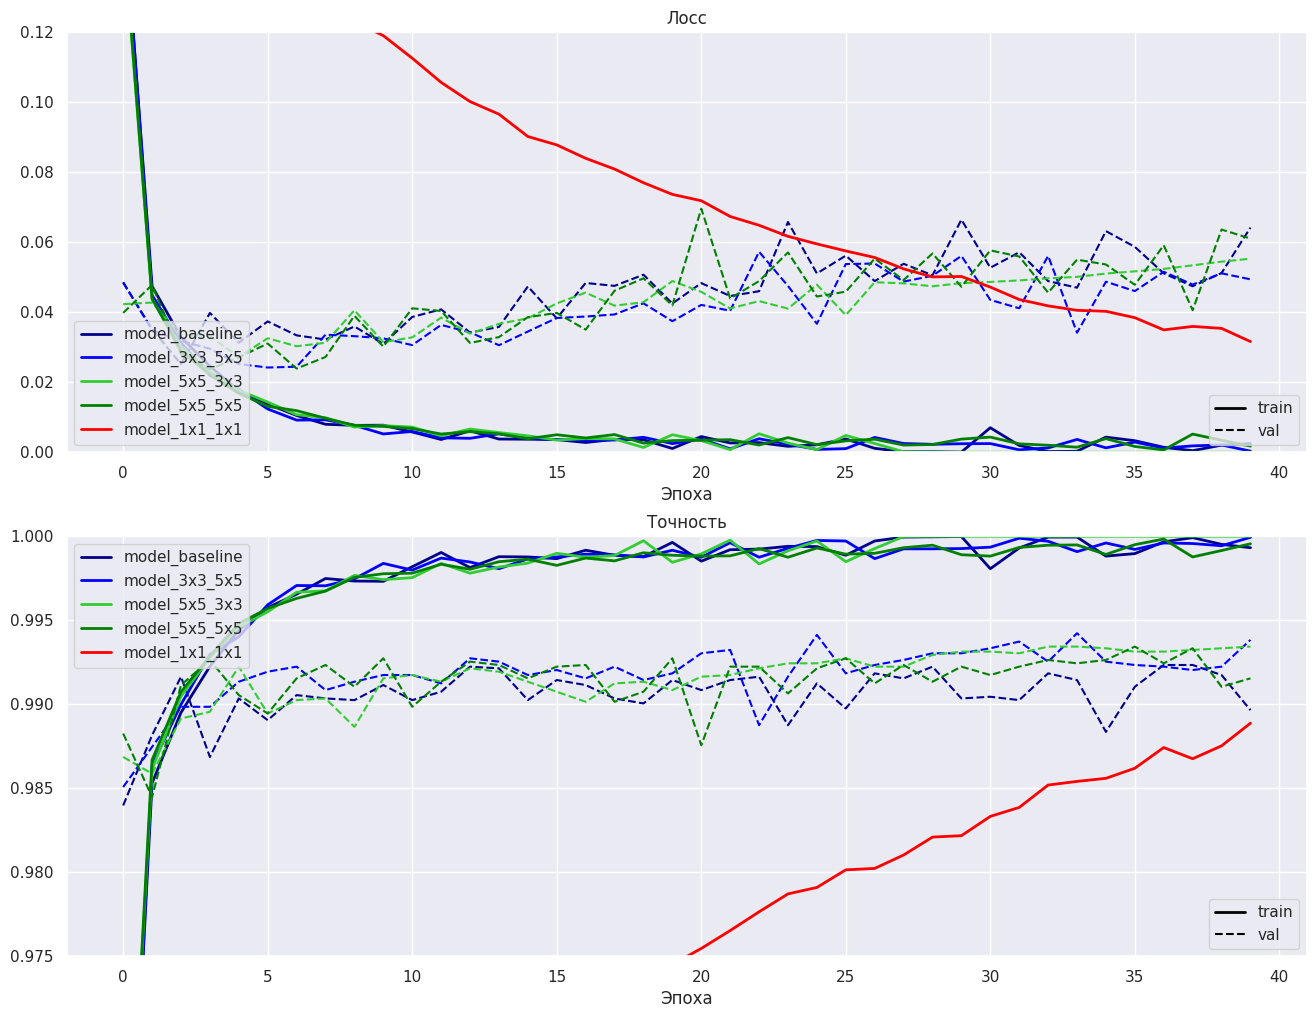

In [76]:
plot_histories(logs)

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2**  
  
**Время обучения:**  
По прогресс-бару tqdm видно, что при увеличении размера ядра время работы немного уменьшается. Это снова контринтуитивно, но вероятно, вызвано теми же эффектами, что и в предыдущем эксперименте. Но вообще, при увеличении размера ядра время работы тоже должно расти, т.к. квадратично от размера ядра растет кол-во операций

**Качество предсказания:**  
По графикам лосса и точности видно, что  
а) эксперимент с ядром 1х1, как и предполагалось, показал худший результат. Ядро 1х1 не выполняет свою главную задачу: не выделяет локальный контекст пикселей (т.к. не смотрит на пиксели в окрестности, а учитывает только центральный), а значит, не улавливает связи между соседними пикселями и паттерны   
б) на трейне и валидации все остальные модели показали себя примерно одинаково. У меня нет надежных оснований выделить какую-либо архитектуру как явно лучшую, но бейзлайн отработал довольно хорошо, поэтому далее возьмем его.  
Можно сделать вывод, что нет явной связи между размером ядер свертки и качеством модели. Ключевой пойнт - размер ядра должен быть небольшим, чтобы свертка могла выделять локальные свойства картинки, и дефолтное значение 3х3 вполне подходит

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.  
Далее будем использовать model_baseline, показавшую точность 99% на валидации  

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [77]:
model_baseline.train(False)
sigmoid = nn.Sigmoid()
predicted_class, predicted_prob, real_class = [], [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        probs = sigmoid(model_baseline(X_batch)).detach().cpu().numpy()
        predicted_class.append(np.argmax(probs, axis=1))  # класс, уверенность сетки в котором максимальна
        predicted_prob.append(np.max(probs, axis=1))  # вероятность того класса
        real_class.append(y_batch.detach().cpu().numpy())
predicted_class, predicted_prob, real_class = [np.concatenate(x, axis=0) for x in [predicted_class, predicted_prob, real_class]]
labels = pd.DataFrame({'Реальный класс':real_class,'Предсказанный класс':predicted_class,'Вероятность класса':predicted_prob}).reset_index()
labels['index'] = labels['index'].astype(int)

Посмотрим точность по всем классам и кол-во объектов каждого класса. Действительно, выглядит очень равномерно, причем датасет хорошо сбалансирован

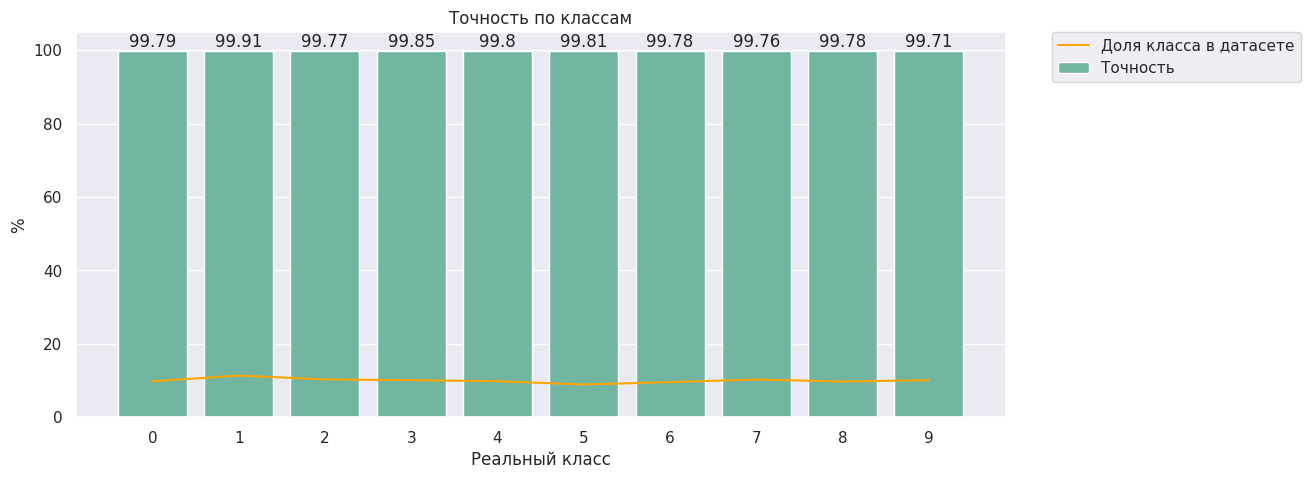

In [78]:
acc_by_cls = {i: accuracy_score(real_class == i, predicted_class == i) * 100 for i in range(10)}
plt.figure(figsize=(12, 5))
ax = sns.barplot(x=list(range(10)), y=[acc_by_cls[i] for i in range(10)], label='Точность')
ax.bar_label(ax.containers[0])
cls_fractions = labels.groupby(by='Реальный класс').count().rename(columns={'index':'%'})
cls_fractions['%'] = cls_fractions['%'] / cls_fractions['%'].sum() * 100
ax = sns.lineplot(cls_fractions, x='Реальный класс', y='%', color='orange', label='Доля класса в датасете')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Точность по классам')
plt.show()

Теперь проанализируем самые серьезные ошибки модели, т.е. посмотрим кадры, которые сеть классифицировала неправильно, но с наибольшей уверенностью

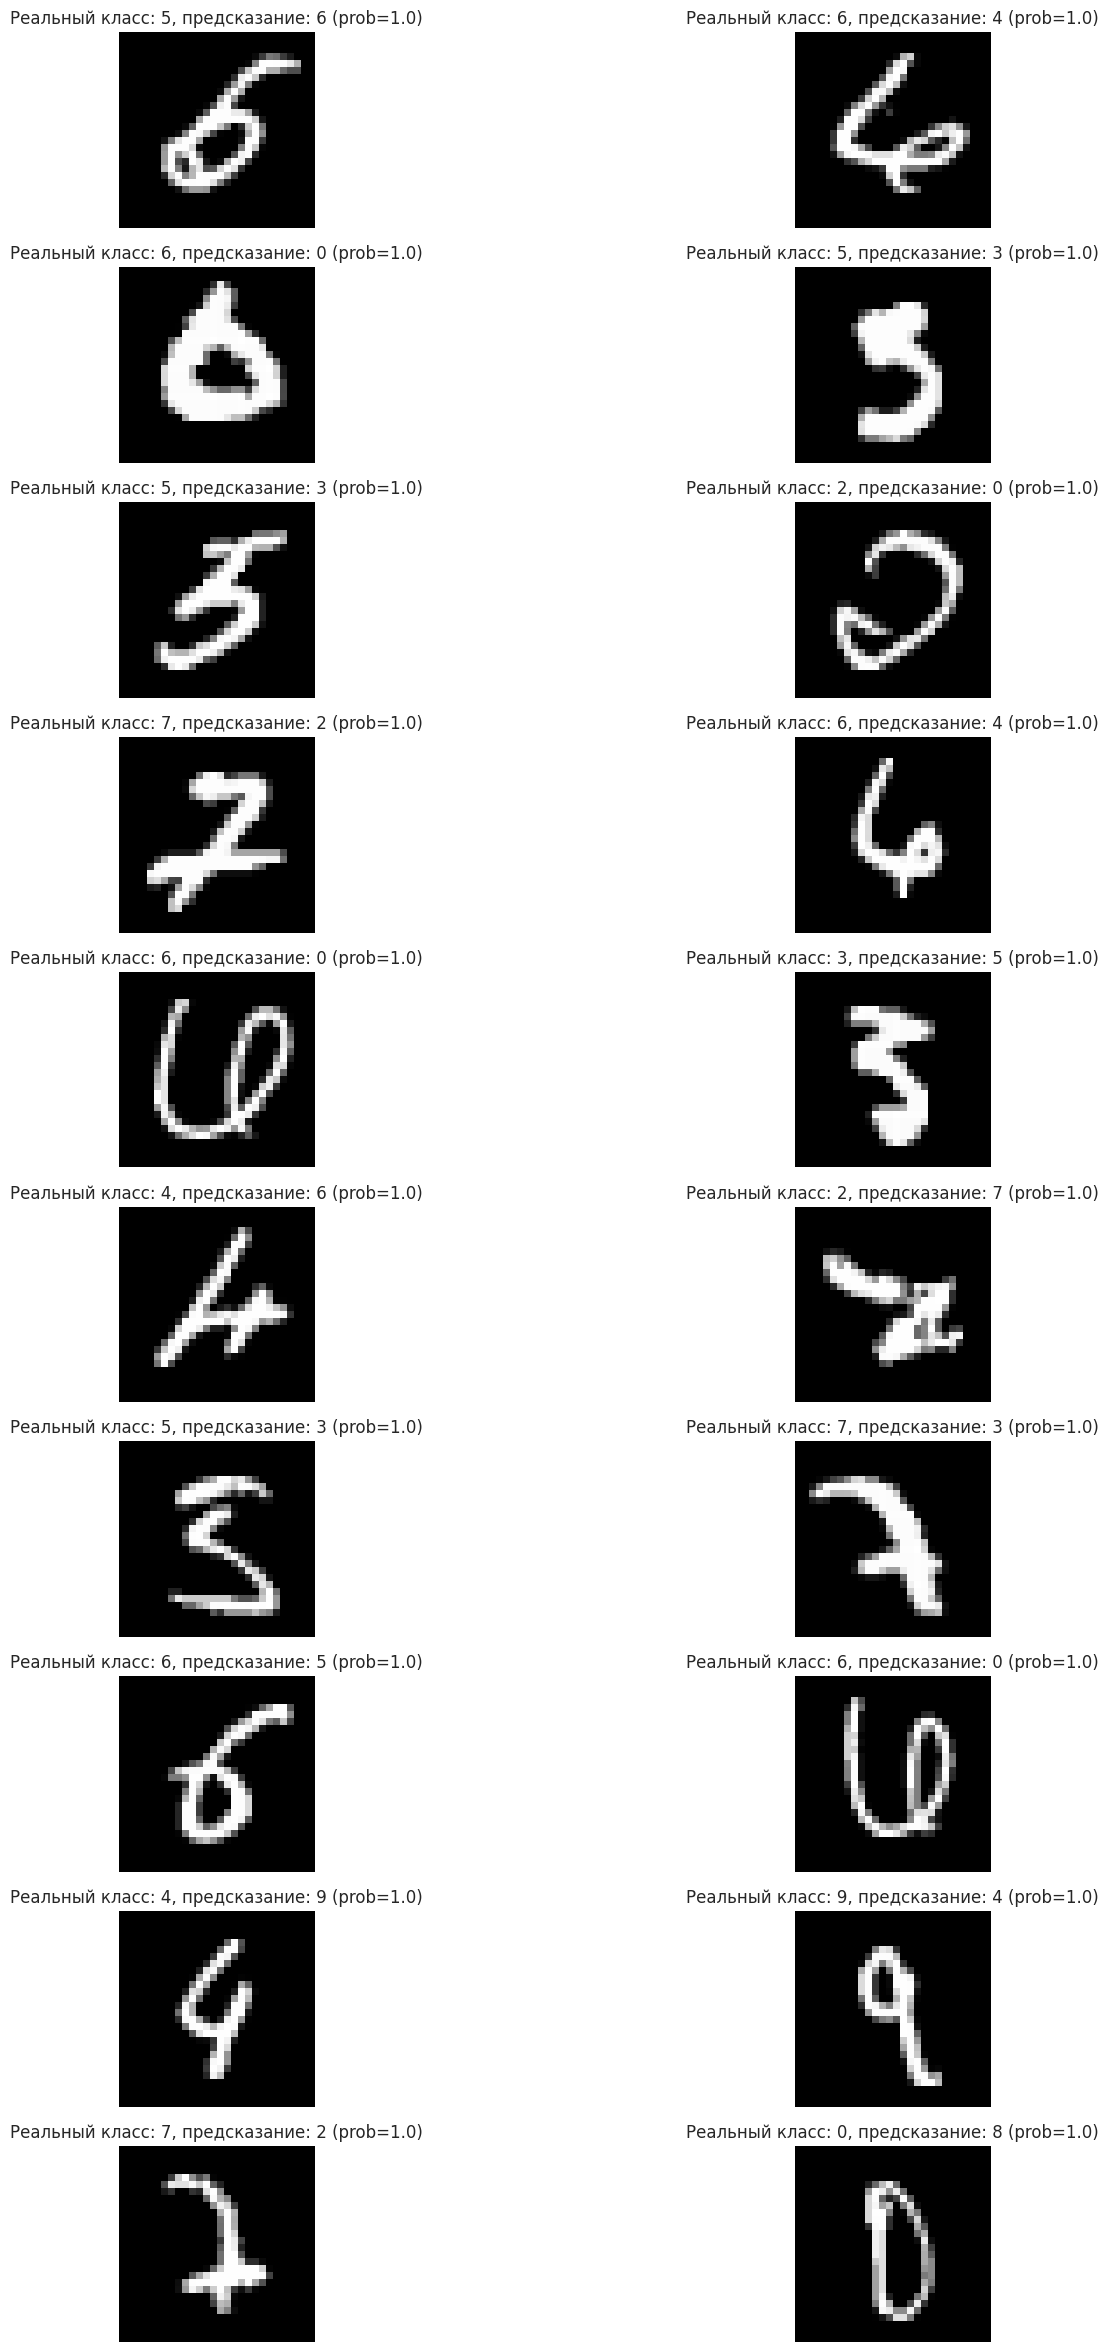

In [79]:
errors = labels[labels['Реальный класс'] != labels['Предсказанный класс']]  # выделим ошибочные предикты
top_errors = errors.sort_values(by=['Вероятность класса'], ascending=False)[:20]  # отсортируем по их вероятностям

plt.figure(figsize=(16, 30))
for i in range(20):
    plt.subplot(10, 2, i+1)
    plt.imshow(val_dataset[int(top_errors.iloc[i]['index'])][0].permute(1, 2, 0).repeat(1, 1, 3))  # 1xHxW -> HxWx3
    plt.title(f"Реальный класс: {int(top_errors.iloc[i]['Реальный класс'])}, предсказание: {int(top_errors.iloc[i]['Предсказанный класс'])} (prob={round(top_errors.iloc[i]['Вероятность класса'], 5)})")
    plt.axis("off")

**Ответ:**  
Точность по классам распределена равномерно, перевеса в пользу какого-либо класса не наблюдается.      
По визуализации ошибок видно, что модель ошибается преимущественно на кадрах, где сложно определить класс даже человеку. Например, на восьмерке, написанной с разрывом, как четверка. Однако отмечу, что встречаются и явные ошибки, где класс, казалось бы, определить заметно проще, а значит, модель потенциально можно улучшать    

**Вывод по всей задаче:**
В ходе задачи удалось сравнить несколько архитектур сверточных нейросетей для задачи классификации изображений. В ходе экспериментов удалось установить, как варьирование различных параметров влияет на точность предсказаний. В итоге была отобрана модель, показывающая >99% точности на валидации, были подробно изучены ее ошибки. Будь это реальная задача, такую модель можно было бы выпускать в прод

---
### Задача 2. Перенос стиля (пусто, потому что дорешка только по 1й задаче)